In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/P8

import os

PROJECT_DIR = '/content/drive/MyDrive/P8'


/content/drive/MyDrive/P8


In [ ]:
# Libraries
import os
import json
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import wordpunct_tokenize
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.special import softmax

import torch
from torch.utils.data import Dataset

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
)


In [ ]:
# File paths

train_json_path = "data/train.json"
test_json_path = "data/gold_test.json"
ct_folder_path = "data/CT json"  # folder with CTR json files


In [ ]:
# JSON helpers

def load_json(file_path):
    # utf-8 to avoid encoding artifacts like "â"
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

# Load raw dicts
data = load_json(train_json_path)
test_df = load_json(test_json_path)




In [ ]:
# Text cleaning & tokenization

import re, unicodedata
try:
    from ftfy import fix_text
    _fix = lambda s: fix_text(s)
except Exception:
    _fix = lambda s: unicodedata.normalize("NFKC", s)

def clean_text(text):
    """
    Normalize free text:
      - repair unicode/mojibake
      - collapse spaces
      - KEEP useful clinical punctuation: / % + - . , < > ^ = ≤ ≥
    Accepts list or string.
    """
    if isinstance(text, list):
        text = " ".join(text)
    text = _fix(str(text))
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^\w\s/%+\-.,<>^=≤≥]", "", text)
    return text

from nltk.tokenize import wordpunct_tokenize
def tokenize_text(text):
    return wordpunct_tokenize(text)

In [ ]:
# Missing-data handling

def handle_missing_data(df, require_label=True):
    """
    Keep rows with essential fields present.
    """
    required = ["ID", "Type", "Section_id", "Primary_id", "Statement"]
    if require_label:
        required.append("Label")

    df = df.dropna(subset=required)

    df["Secondary_id"] = df["Secondary_id"].fillna("")
    return df


In [ ]:
# Build DataFrames from raw dicts

def preprocess_data(raw_dict, require_label=True):
    rows = []
    for key, value in raw_dict.items():
        rows.append({
            "ID": key,
            "Type": value.get("Type"),
            "Section_id": value.get("Section_id"),
            "Primary_id": value.get("Primary_id"),
            "Secondary_id": value.get("Secondary_id", ""),
            "Statement": clean_text(value.get("Statement", "")),
            "Label": value.get("Label")
        })
    df = pd.DataFrame(rows)
    df = handle_missing_data(df, require_label=require_label)
    return df


In [ ]:
# Create train / test DataFrames
df = preprocess_data(data, require_label=True)
df_test = preprocess_data(test_df, require_label=False)

df.head()

,ID,Type,Section_id,Primary_id,Secondary_id,Statement,Label
0,5bc844fc-e852-4270-bfaf-36ea9eface3d,Comparison,Intervention,NCT01928186,NCT00684983,All the primary trial participants do not rece...,Contradiction
1,86b7cb3d-6186-4a04-9aa6-b174ab764eed,Single,Eligibility,NCT00662129,,"Patients with Platelet count over 100,000/mm â...",Contradiction
2,dbed5471-c2fc-45b5-b26f-430c9fa37a37,Comparison,Adverse Events,NCT00093145,NCT00703326,Heart-related adverse events were recorded in ...,Entailment
3,20c35c89-8d23-4be3-b603-ac0ee0f3b4de,Single,Eligibility,NCT01097642,,Adult Patients with histologic confirmation of...,Contradiction
4,f17cb242-419d-4f5d-bfa4-41494ed5ac0e,Comparison,Intervention,NCT00852930,NCT02308020,Laser Therapy is in each cohort of the primary...,Contradiction


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df_test.head()

,ID,Type,Section_id,Primary_id,Secondary_id,Statement,Label
0,26145056-fdfd-4f2d-909e-be84fc53ede8,Single,Results,NCT00248547,,Patients receiving the placebo intervention in...,Entailment
1,22384b11-eb42-42da-86b3-dfed559ebb77,Single,Results,NCT01106898,,Only 2 patients in the primary trial did not h...,Entailment
2,b03bae0b-6811-4c4d-a265-98c0f4ae7f1f,Comparison,Eligibility,NCT00800436,NCT00702949,patients who have received gabapentin or herce...,Contradiction
3,1b2048ba-33c8-43d1-8d8f-bca70ca8d80c,Comparison,Intervention,NCT02222922,NCT00496860,the drug dosage for the primary clinical trial...,Entailment
4,f398c658-74cb-4d2b-894c-d785e4dde994,Comparison,Results,NCT01631552,NCT01286987,the primary clinical trial and secondary clini...,Entailment


In [ ]:
# Extract premises from CTR JSONs

def extract_premises(ct_folder, df):
    """
    For each row, open CTR json for Primary_id and (optional) Secondary_id,
    and fetch the text of the row's Section_id.
    """
    def _clean_premise(x):
        x = " ".join(x) if isinstance(x, list) else str(x)
        return re.sub(r"\s+", " ", x).strip()

    premises = {}
    for _, row in df.iterrows():
        sec = str(row["Section_id"])
        # Primary
        p_text = ""
        p_path = os.path.join(ct_folder, f"{row['Primary_id']}.json")
        if os.path.exists(p_path):
            with open(p_path, "r", encoding="utf-8") as f:
                p_text = _clean_premise(json.load(f).get(sec, ""))

        # Secondary (optional)
        s_text = ""
        sid = str(row.get("Secondary_id") or "").strip()
        if sid:
            s_path = os.path.join(ct_folder, f"{sid}.json")
            if os.path.exists(s_path):
                with open(s_path, "r", encoding="utf-8") as f:
                    s_text = _clean_premise(json.load(f).get(sec, ""))

        premises[row["ID"]] = {
            "Primary_premise": p_text,
            "Secondary_premise": s_text
        }
    return premises

premises = extract_premises(ct_folder_path, df)
premises_test = extract_premises(ct_folder_path, df_test)


In [ ]:
# Merge premises back

prem_df = pd.DataFrame.from_dict(premises, orient="index").rename_axis("ID").reset_index()
df = df.merge(prem_df, on="ID", how="left")

prem_test_df = pd.DataFrame.from_dict(premises_test, orient="index").rename_axis("ID").reset_index()
df_test = df_test.merge(prem_test_df, on="ID", how="left")

# Fill missing premise strings to avoid None downstream
for col in ["Primary_premise", "Secondary_premise"]:
    df[col] = df[col].fillna("")
    df_test[col] = df_test[col].fillna("")


In [ ]:
# Final normalize tokens, and sentence splits for premises

for _df in (df, df_test):
    _df["Statement_clean"] = _df["Statement"].apply(clean_text)
    _df["Tokens"] = _df["Statement_clean"].apply(tokenize_text)

    _df["Premise_text"] = (
        _df["Primary_premise"].fillna("") + " " + _df["Secondary_premise"].fillna("")
    ).str.strip()

    _df["Premise_sents"] = _df["Premise_text"].apply(split_sents)


In [ ]:
# Leak-free split (grouped by trial components)

def split_dataset(df, val_size=0.20, seed=42):
    # tiny union-find over trial IDs so comparisons share a component
    parent = {}
    def find(x):
        parent.setdefault(x, x)
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    def union(a, b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra

    P = df["Primary_id"].astype(str)
    S = df["Secondary_id"].astype(str).fillna("")

    for p, s in zip(P, S):
        parent.setdefault(p, p)
        if s and s.lower() != "nan":
            parent.setdefault(s, s)
            union(p, s)

    # Group per row = component of its Primary_id
    groups = P.map(find)

    # Stratify by label if available (binary: startswith 'entail')
    y = df["Label"].astype(str).str.lower().str.startswith("entail").astype(int)

    try:
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
        tr_idx, va_idx = next(sgkf.split(df, y, groups))
    except Exception:
        gss = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
        tr_idx, va_idx = next(gss.split(df, groups=groups))

    train = df.iloc[tr_idx].reset_index(drop=True)
    validation = df.iloc[va_idx].reset_index(drop=True)

    # Safety: no trial overlap
    def _trials(d):
        return (set(d["Primary_id"].astype(str)) | set(d["Secondary_id"].astype(str))) - {""}
    assert len(_trials(train) & _trials(validation)) == 0, "Leak detected."

    return train, validation

train_df, validation_df = split_dataset(df)


In [ ]:
train_df.head()

,ID,Type,Section_id,Primary_id,Secondary_id,Statement,Label,Primary_premise,Secondary_premise,Statement_clean,Tokens,Premise_text,Premise_sents
0,5bc844fc-e852-4270-bfaf-36ea9eface3d,Comparison,Intervention,NCT01928186,NCT00684983,All the primary trial participants do not rece...,Contradiction,INTERVENTION 1: Diagnostic (FLT PET) Patients ...,INTERVENTION 1: Arm A Patients receive oral ca...,All the primary trial participants do not rece...,"[All, the, primary, trial, participants, do, n...",INTERVENTION 1: Diagnostic (FLT PET) Patients ...,"[INTERVENTION 1:, Diagnostic (FLT PET) Patient..."
1,86b7cb3d-6186-4a04-9aa6-b174ab764eed,Single,Eligibility,NCT00662129,,"Patients with Platelet count over 100,000/mm â...",Contradiction,DISEASE CHARACTERISTICS: Histologically or cyt...,,"Patients with Platelet count over 100,000/mm â...","[Patients, with, Platelet, count, over, 100, ,...",DISEASE CHARACTERISTICS: Histologically or cyt...,"[DISEASE CHARACTERISTICS:, Histologically or c..."
2,dbed5471-c2fc-45b5-b26f-430c9fa37a37,Comparison,Adverse Events,NCT00093145,NCT00703326,Heart-related adverse events were recorded in ...,Entailment,Adverse Events 1: Total: 5/32 (15.63%) Febrile...,Adverse Events 1: Total: 285/752 (37.90%) Anae...,Heart-related adverse events were recorded in ...,"[Heart, -, related, adverse, events, were, rec...",Adverse Events 1: Total: 5/32 (15.63%) Febrile...,"[Adverse Events 1:, Total:, 5/32 (15.63%) Febr..."
3,20c35c89-8d23-4be3-b603-ac0ee0f3b4de,Single,Eligibility,NCT01097642,,Adult Patients with histologic confirmation of...,Contradiction,Inclusion Criteria: Patients with histologic c...,,Adult Patients with histologic confirmation of...,"[Adult, Patients, with, histologic, confirmati...",Inclusion Criteria: Patients with histologic c...,"[Inclusion Criteria:, Patients with histologic..."
4,f17cb242-419d-4f5d-bfa4-41494ed5ac0e,Comparison,Intervention,NCT00852930,NCT02308020,Laser Therapy is in each cohort of the primary...,Contradiction,INTERVENTION 1: Laser Therapy Alone therapist ...,"INTERVENTION 1: Part A Abemaciclib: HR+, HER2+...",Laser Therapy is in each cohort of the primary...,"[Laser, Therapy, is, in, each, cohort, of, the...",INTERVENTION 1: Laser Therapy Alone therapist ...,"[INTERVENTION 1:, Laser Therapy Alone therapis..."


In [ ]:
validation_df.head()

,ID,Type,Section_id,Primary_id,Secondary_id,Statement,Label,Primary_premise,Secondary_premise,Statement_clean,Tokens,Premise_text,Premise_sents
0,96b77cdd-aa9f-4770-8447-8a04d9ca5da7,Single,Eligibility,NCT00633750,,Patients with Clinical stage II T2 N1 invasive...,Contradiction,Inclusion Criteria: Clinical stage I or II (T1...,,Patients with Clinical stage II T2 N1 invasive...,"[Patients, with, Clinical, stage, II, T2, N1, ...",Inclusion Criteria: Clinical stage I or II (T1...,"[Inclusion Criteria:, Clinical stage I or II (..."
1,c3257f7b-f5b4-4a9c-8a8f-b037f27caa8f,Single,Eligibility,NCT00058058,,Candidates for the primary trial must have a l...,Contradiction,DISEASE CHARACTERISTICS: Recently confirmed un...,,Candidates for the primary trial must have a l...,"[Candidates, for, the, primary, trial, must, h...",DISEASE CHARACTERISTICS: Recently confirmed un...,"[DISEASE CHARACTERISTICS:, Recently confirmed ..."
2,d3590771-806b-4754-a455-38113bfedfca,Single,Eligibility,NCT00952692,,Candidates for the primary trial must have ade...,Contradiction,Inclusion Criteria: The following criteria are...,,Candidates for the primary trial must have ade...,"[Candidates, for, the, primary, trial, must, h...",Inclusion Criteria: The following criteria are...,"[Inclusion Criteria:, The following criteria a..."
3,15c83d26-f9ba-44cc-a920-6941781cdd8b,Single,Adverse Events,NCT01427933,,Neutropenia affected the majority of patients ...,Contradiction,Adverse Events 1: Total: 26/69 (37.68%) Anaemi...,,Neutropenia affected the majority of patients ...,"[Neutropenia, affected, the, majority, of, pat...",Adverse Events 1: Total: 26/69 (37.68%) Anaemi...,"[Adverse Events 1:, Total:, 26/69 (37.68%) Ana..."
4,b4c97206-66fd-468b-8388-fac076222c10,Single,Adverse Events,NCT00863655,,There were 7 more cases of Anaemia and 1 more ...,Contradiction,Adverse Events 1: Total: 158/482 (32.78%) Anae...,,There were 7 more cases of Anaemia and 1 more ...,"[There, were, 7, more, cases, of, Anaemia, and...",Adverse Events 1: Total: 158/482 (32.78%) Anae...,"[Adverse Events 1:, Total:, 158/482 (32.78%) A..."


In [ ]:
df_test.head()

,ID,Type,Section_id,Primary_id,Secondary_id,Statement,Label,Primary_premise,Secondary_premise,Statement_clean,Tokens,Premise_text,Premise_sents
0,26145056-fdfd-4f2d-909e-be84fc53ede8,Single,Results,NCT00248547,,Patients receiving the placebo intervention in...,Entailment,Outcome Measurement: Number of Emesis Free Par...,,Patients receiving the placebo intervention in...,"[Patients, receiving, the, placebo, interventi...",Outcome Measurement: Number of Emesis Free Par...,"[Outcome Measurement:, Number of Emesis Free P..."
1,22384b11-eb42-42da-86b3-dfed559ebb77,Single,Results,NCT01106898,,Only 2 patients in the primary trial did not h...,Entailment,Outcome Measurement: Recurrence-free Survival ...,,Only 2 patients in the primary trial did not h...,"[Only, 2, patients, in, the, primary, trial, d...",Outcome Measurement: Recurrence-free Survival ...,"[Outcome Measurement:, Recurrence-free Surviva..."
2,b03bae0b-6811-4c4d-a265-98c0f4ae7f1f,Comparison,Eligibility,NCT00800436,NCT00702949,patients who have received gabapentin or herce...,Contradiction,Inclusion Criteria: Healthy Participants (Part...,DISEASE CHARACTERISTICS: Meeting 1 of the foll...,patients who have received gabapentin or herce...,"[patients, who, have, received, gabapentin, or...",Inclusion Criteria: Healthy Participants (Part...,"[Inclusion Criteria:, Healthy Participants (Pa..."
3,1b2048ba-33c8-43d1-8d8f-bca70ca8d80c,Comparison,Intervention,NCT02222922,NCT00496860,the drug dosage for the primary clinical trial...,Entailment,INTERVENTION 1: PF-06647020 0.2 mg/kg（Q3W Regi...,INTERVENTION 1: ALT-801 0.015 mg/kg/Dose 0.015...,the drug dosage for the primary clinical trial...,"[the, drug, dosage, for, the, primary, clinica...",INTERVENTION 1: PF-06647020 0.2 mg/kg（Q3W Regi...,"[INTERVENTION 1:, PF-06647020 0.2 mg/kg（Q3W Re..."
4,f398c658-74cb-4d2b-894c-d785e4dde994,Comparison,Results,NCT01631552,NCT01286987,the primary clinical trial and secondary clini...,Entailment,Outcome Measurement: Percentage of Participant...,Outcome Measurement: Number of Participants Wi...,the primary clinical trial and secondary clini...,"[the, primary, clinical, trial, and, secondary...",Outcome Measurement: Percentage of Participant...,"[Outcome Measurement:, Percentage of Participa..."


In [ ]:
# Statement length stats
for name, df in [("Train", train_df), ("Test", df_test)]:
    if "Statement" in df.columns:
        s = df["Statement"].dropna().astype(str).str.len()
        if len(s):
            print(f"\n{name} Statement length — count={len(s)}, mean={s.mean():.1f}, median={s.median():.0f}, p90={s.quantile(0.9):.0f}, max={s.max():.0f}")
        else:
            print(f"\n{name}: `Statement` is empty.")
    else:
        print(f"\n{name}: `Statement` column not found.")



Train Statement length — count=1410, mean=119.8, median=111, p90=176, max=334

Test Statement length — count=5500, mean=174.8, median=162, p90=275, max=491


In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

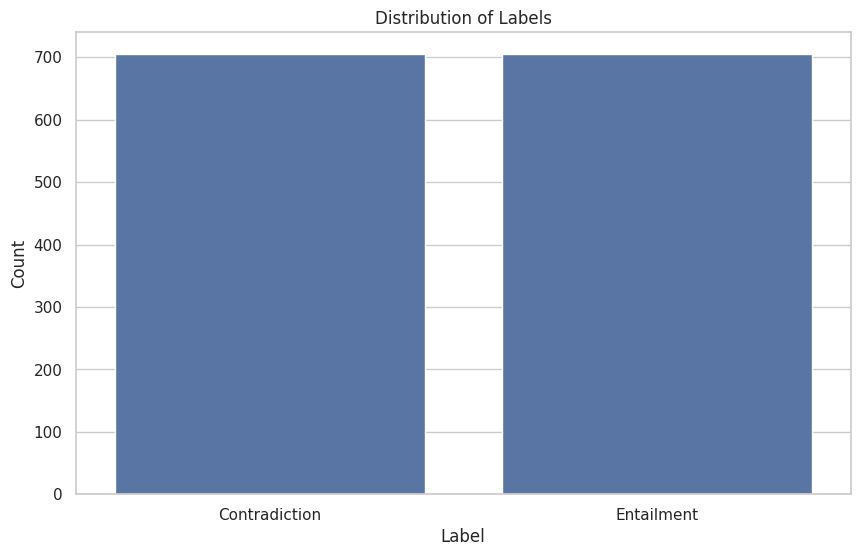

In [ ]:
# What is the distribution of labels?
def plot_label_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index)
    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_label_distribution(train_df)

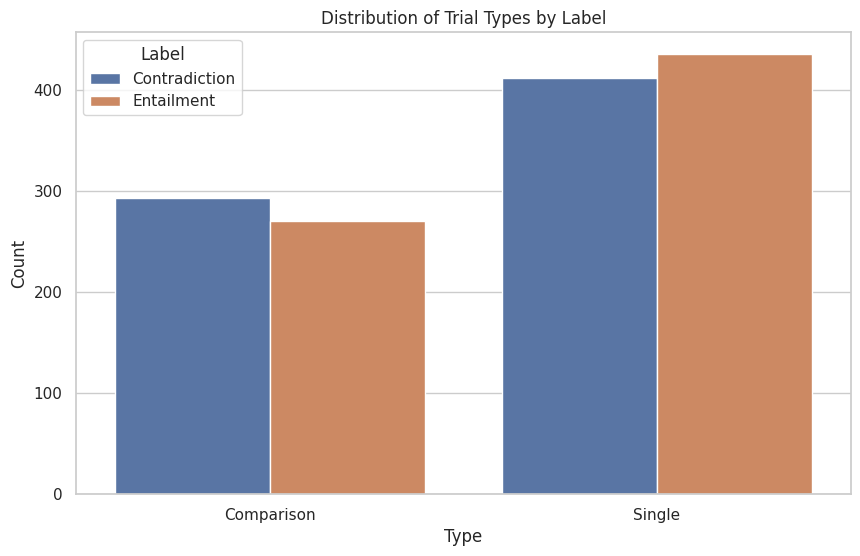

In [ ]:
# Are there any patterns or anomalies in the data distribution based on the type of trial (Comparison vs. Single)?
def plot_type_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Type', hue='Label', data=df)
    plt.title('Distribution of Trial Types by Label')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.show()

plot_type_distribution(train_df)

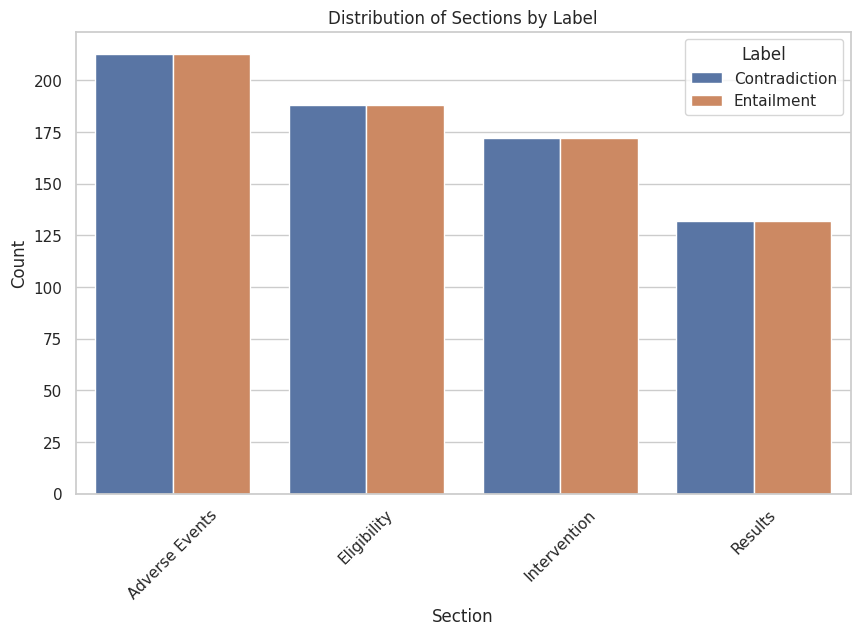

In [ ]:
# How are the sections distributed across the dataset?
def plot_section_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Section_id', hue='Label', data=df, order=df['Section_id'].value_counts().index)
    plt.title('Distribution of Sections by Label')
    plt.xlabel('Section')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

plot_section_distribution(train_df)

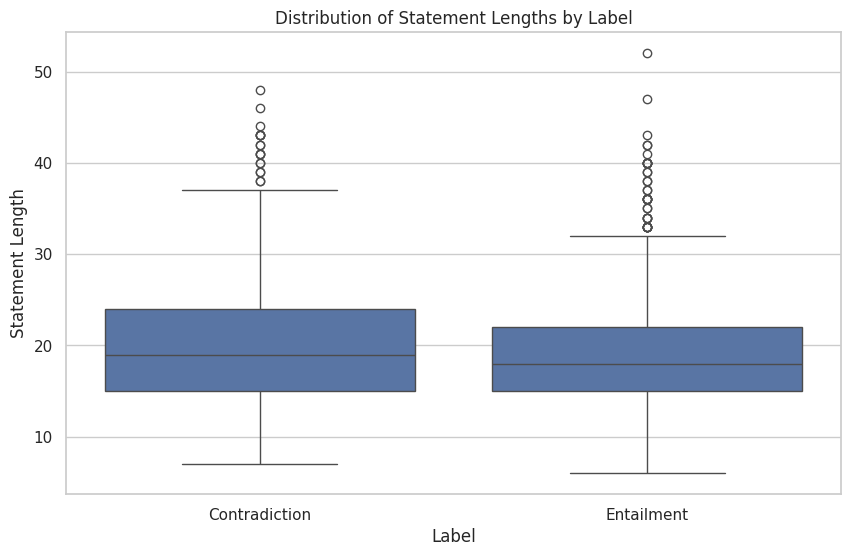

In [ ]:
# Boxplot of statement lengths by label
def plot_statement_length(df):
    df['Statement_Length'] = df['Statement'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Label', y='Statement_Length', data=df)
    plt.title('Distribution of Statement Lengths by Label')
    plt.xlabel('Label')
    plt.ylabel('Statement Length')
    plt.show()

plot_statement_length(train_df)

In [ ]:
# Build inputs
def build_inputs(row, tokenizer, max_len=512, premise_text=None, long_model=False):
    statement = (row.get("Statement_raw") or row.get("Statement") or "").strip()
    if premise_text is None:
        primary   = (row.get("Primary_premise")   or "").strip()
        secondary = (row.get("Secondary_premise") or "").strip()
        premise_text = f"{primary} {tokenizer.sep_token} {secondary}" if secondary else primary

    enc = tokenizer(
        premise_text, statement,
        add_special_tokens=True,
        truncation="longest_first",   # trims premise; keeps statement intact
        max_length=max_len,
        return_attention_mask=True,
        padding=False,
    )

    return enc

In [ ]:
# Dataset (return plain lists; collator pads & tensorizes)
class NLIDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512, has_labels=True,
                 precomputed_premise=None, long_model=False):
        self.df = df.reset_index(drop=True)
        self.tk = tokenizer
        self.max_len = max_len
        self.has_labels = has_labels and ("Label_encoded" in df.columns)
        self.pre_prem = None if precomputed_premise is None else list(precomputed_premise)
        self.long_model = long_model

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i].to_dict()
        prem = None if self.pre_prem is None else self.pre_prem[i]
        feat = build_inputs(row, tokenizer=self.tk, max_len=self.max_len,
                            premise_text=prem, long_model=self.long_model)
        if self.has_labels:
            feat["labels"] = int(row["Label_encoded"])
        return feat


In [ ]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
import numpy as np, torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import random

def compute_metrics(eval_pred):
    try:
        logits, labels = eval_pred.predictions, eval_pred.label_ids
    except AttributeError:
        logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    mf1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1, "macro_f1": mf1}

def _seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_eval_model_simple(model_name,
                            train_df, val_df, df_test,
                            max_len=512, epochs=5, lr=2e-5, bsz=16,
                            use_premise_short=False, seed=42,
                            return_objects=False):

    _seed_everything(seed)

    tok   = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    max_len = min(max_len, getattr(tok, "model_max_length", max_len))

    prem_tr = train_df["Premise_short"].tolist() if use_premise_short and "Premise_short" in train_df.columns else None
    prem_va = val_df["Premise_short"].tolist()   if use_premise_short and "Premise_short" in val_df.columns else None

    train_ds = NLIDataset(train_df, tok, max_len=max_len, has_labels=True, precomputed_premise=prem_tr)
    val_ds   = NLIDataset(val_df,   tok, max_len=max_len, has_labels=True, precomputed_premise=prem_va)

    collator = DataCollatorWithPadding(tokenizer=tok, return_tensors="pt", pad_to_multiple_of=8)

    args = TrainingArguments(
        output_dir=f"outputs/{model_name.split('/')[-1]}",
        per_device_train_batch_size=bsz,
        per_device_eval_batch_size=bsz,
        num_train_epochs=epochs,
        learning_rate=lr,
        weight_decay=0.01,
        seed=seed,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model, args=args,
        train_dataset=train_ds, eval_dataset=val_ds,
        tokenizer=tok, data_collator=collator,
        compute_metrics=compute_metrics,
    )


    train_out = trainer.train()


    tr = trainer.evaluate(train_ds)
    va = trainer.evaluate(val_ds)


    train_loss = train_out.metrics.get("train_loss", train_out.metrics.get("loss"))
    summary = {
        "train_loss": float(train_loss) if train_loss is not None else None,

        "train_eval_loss":                 float(tr.get("eval_loss", np.nan)),
        "train_eval_accuracy":             float(tr.get("eval_accuracy", np.nan)),
        "train_eval_precision":            float(tr.get("eval_precision", np.nan)),
        "train_eval_recall":               float(tr.get("eval_recall", np.nan)),
        "train_eval_f1":                   float(tr.get("eval_f1", np.nan)),
        "train_eval_macro_f1":             float(tr.get("eval_macro_f1", np.nan)),
        "train_eval_runtime":              float(tr.get("eval_runtime", np.nan)),
        "train_eval_samples_per_second":   float(tr.get("eval_samples_per_second", np.nan)),
        "train_eval_steps_per_second":     float(tr.get("eval_steps_per_second", np.nan)),

        "val_eval_loss":                   float(va.get("eval_loss", np.nan)),
        "val_eval_accuracy":               float(va.get("eval_accuracy", np.nan)),
        "val_eval_precision":              float(va.get("eval_precision", np.nan)),
        "val_eval_recall":                 float(va.get("eval_recall", np.nan)),
        "val_eval_f1":                     float(va.get("eval_f1", np.nan)),
        "val_eval_macro_f1":               float(va.get("eval_macro_f1", np.nan)),
        "val_eval_runtime":                float(va.get("eval_runtime", np.nan)),
        "val_eval_samples_per_second":     float(va.get("eval_samples_per_second", np.nan)),
        "val_eval_steps_per_second":       float(va.get("eval_steps_per_second", np.nan)),
    }


    summary.update({
        "model": model_name,
        "use_premise_short": bool(use_premise_short),
        "max_len": int(max_len),
        "epochs": int(epochs),
        "lr": float(lr),
        "bsz": int(bsz),
        "seed": int(seed),
    })

    if return_objects:
        return summary, trainer, tok
    return summary


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["Label_encoded"] = le.fit_transform(train_df["Label"])
validation_df["Label_encoded"] = le.transform(validation_df["Label"])
if "Label" in df_test.columns:
    df_test["Label_encoded"] = le.transform(df_test["Label"])


In [ ]:
res_bert = train_eval_model_simple("bert-base-uncased",
                                   train_df, validation_df, df_test=None
                                  )
res_bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2083349897.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'train_loss': 0.6960383383075842,
 'train_eval_loss': 0.6733197569847107,
 'train_eval_accuracy': 0.5985815602836879,
 'train_eval_precision': 0.6119162640901772,
 'train_eval_recall': 0.5390070921985816,
 'train_eval_f1': 0.5731523378582202,
 'train_eval_macro_f1': 0.5971518048059508,
 'train_eval_runtime': 11.9721,
 'train_eval_samples_per_second': 117.774,
 'train_eval_steps_per_second': 7.434,
 'val_eval_loss': 0.686786949634552,
 'val_eval_accuracy': 0.5275862068965518,
 'val_eval_precision': 0.5416666666666666,
 'val_eval_recall': 0.3586206896551724,
 'val_eval_f1': 0.4315352697095436,
 'val_eval_macro_f1': 0.5137027380996095,
 'val_eval_runtime': 2.4891,
 'val_eval_samples_per_second': 116.51,
 'val_eval_steps_per_second': 7.633,
 'model': 'bert-base-uncased',
 'use_premise_short': False,
 'max_len': 512,
 'epochs': 5,
 'lr': 2e-05,
 'bsz': 16,
 'seed': 42}

In [ ]:
res_pubmed = train_eval_model_simple(
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    train_df, validation_df, df_test=None
  )
res_pubmed


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2083349897.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'train_loss': 0.6966180351343048,
 'train_eval_loss': 0.679182231426239,
 'train_eval_accuracy': 0.573049645390071,
 'train_eval_precision': 0.604887983706721,
 'train_eval_recall': 0.42127659574468085,
 'train_eval_f1': 0.49665551839464883,
 'train_eval_macro_f1': 0.5629829316111175,
 'train_eval_runtime': 11.7295,
 'train_eval_samples_per_second': 120.209,
 'train_eval_steps_per_second': 7.588,
 'val_eval_loss': 0.6881827712059021,
 'val_eval_accuracy': 0.5275862068965518,
 'val_eval_precision': 0.5476190476190477,
 'val_eval_recall': 0.31724137931034485,
 'val_eval_f1': 0.4017467248908297,
 'val_eval_macro_f1': 0.5057166672887197,
 'val_eval_runtime': 2.4875,
 'val_eval_samples_per_second': 116.581,
 'val_eval_steps_per_second': 7.638,
 'model': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
 'use_premise_short': False,
 'max_len': 512,
 'epochs': 5,
 'lr': 2e-05,
 'bsz': 16,
 'seed': 42}

In [ ]:
res_clinical = train_eval_model_simple(
    "emilyalsentzer/Bio_ClinicalBERT",
    train_df, validation_df, df_test=None
)
res_clinical

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2083349897.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Step,Training Loss


{'train_loss': 0.6955529373683287,
 'train_eval_loss': 0.6754129528999329,
 'train_eval_accuracy': 0.5893617021276596,
 'train_eval_precision': 0.6137184115523465,
 'train_eval_recall': 0.48226950354609927,
 'train_eval_f1': 0.5401111993645751,
 'train_eval_macro_f1': 0.5845975599641582,
 'train_eval_runtime': 11.9611,
 'train_eval_samples_per_second': 117.882,
 'train_eval_steps_per_second': 7.441,
 'val_eval_loss': 0.690586268901825,
 'val_eval_accuracy': 0.5379310344827586,
 'val_eval_precision': 0.5567010309278351,
 'val_eval_recall': 0.3724137931034483,
 'val_eval_f1': 0.4462809917355372,
 'val_eval_macro_f1': 0.5249156437967627,
 'val_eval_runtime': 2.4903,
 'val_eval_samples_per_second': 116.452,
 'val_eval_steps_per_second': 7.63,
 'model': 'emilyalsentzer/Bio_ClinicalBERT',
 'use_premise_short': False,
 'max_len': 512,
 'epochs': 5,
 'lr': 2e-05,
 'bsz': 16,
 'seed': 42}

In [ ]:
res_deb = train_eval_model_simple(
    "microsoft/deberta-v3-base",
    train_df, validation_df, df_test=None
    )
res_deb


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2083349897.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Step,Training Loss


{'train_loss': 0.6959749714712079,
 'train_eval_loss': 0.6930631995201111,
 'train_eval_accuracy': 0.5056737588652482,
 'train_eval_precision': 0.5043478260869565,
 'train_eval_recall': 0.6581560283687943,
 'train_eval_f1': 0.571076923076923,
 'train_eval_macro_f1': 0.4939066623752816,
 'train_eval_runtime': 29.9154,
 'train_eval_samples_per_second': 47.133,
 'train_eval_steps_per_second': 2.975,
 'val_eval_loss': 0.6930789947509766,
 'val_eval_accuracy': 0.503448275862069,
 'val_eval_precision': 0.5028571428571429,
 'val_eval_recall': 0.6068965517241379,
 'val_eval_f1': 0.55,
 'val_eval_macro_f1': 0.4980769230769231,
 'val_eval_runtime': 6.2488,
 'val_eval_samples_per_second': 46.409,
 'val_eval_steps_per_second': 3.041,
 'model': 'microsoft/deberta-v3-base',
 'use_premise_short': False,
 'max_len': 512,
 'epochs': 5,
 'lr': 2e-05,
 'bsz': 16,
 'seed': 42}

In [ ]:
bert = dict(
    model="bert-base-uncased",
    train_macro_f1=0.5971518048059508, val_macro_f1=0.5137027380996095,
    train_precision=0.6119162640901772, val_precision=0.5416666666666666,
    train_recall=0.5390070921985816,  val_recall=0.3586206896551724
)
pubmed = dict(
    model="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    train_macro_f1=0.5629829316111175, val_macro_f1=0.5057166672887197,
    train_precision=0.604887983706721, val_precision=0.5476190476190477,
    train_recall=0.42127659574468085,  val_recall=0.31724137931034485
)
clinical = dict(
    model="emilyalsentzer/Bio_ClinicalBERT",
    train_macro_f1= 0.5845975599641582, val_macro_f1=0.5249156437967627,
    train_precision=0.6137184115523465, val_precision=0.5567010309278351,
    train_recall=0.48226950354609927,  val_recall=0.3724137931034483
)
deberta = dict(
    model="microsoft/deberta-v3-base",
    train_macro_f1=0.4939066623752816, val_macro_f1=0.4980769230769231,
    train_precision=0.5032608695652174, val_precision=0.5028571428571429,
    train_recall=0.6581560283687943,   val_recall=0.6068965517241379
)

runs = [bert, pubmed, clinical, deberta]

def short_name(s): return s.split("/")[-1]

df = pd.DataFrame([{
    "Model": short_name(r["model"]),
    "Train Macro-F1": r["train_macro_f1"],
    "Val Macro-F1":   r["val_macro_f1"],
    "Train Precision": r["train_precision"],
    "Val Precision":   r["val_precision"],
    "Train Recall": r["train_recall"],
    "Val Recall":   r["val_recall"],
} for r in runs]).sort_values("Val Macro-F1", ascending=False)

df_display = df.copy().round(3)
df_display


,Model,Train Macro-F1,Val Macro-F1,Train Precision,Val Precision,Train Recall,Val Recall
2,Bio_ClinicalBERT,0.585,0.525,0.614,0.557,0.482,0.372
0,bert-base-uncased,0.597,0.514,0.612,0.542,0.539,0.359
1,BiomedNLP-PubMedBERT-base-uncased-abstract-ful...,0.563,0.506,0.605,0.548,0.421,0.317
3,deberta-v3-base,0.494,0.498,0.503,0.503,0.658,0.607


In [ ]:
best_model_1 = "bert-base-uncased"
res_best1, trainer1, tok1 = train_eval_model_simple(
    best_model_1,
    train_df, validation_df, df_test,
    max_len=512, epochs=5, bsz=16, use_premise_short=False,
    return_objects=True
)

def eval_confusion(name, trainer, tok, df_test, max_len=512):
    test_ds = NLIDataset(df_test, tok, max_len=max_len, has_labels=True)
    pred   = trainer.predict(test_ds)
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # 0=Contradiction, 1=Entailment
    cm_df = pd.DataFrame(cm,
        index=["True:Contradiction","True:Entailment"],
        columns=["Pred:Contradiction","Pred:Entailment"]
    )
    print(f"\n=== Confusion matrix — {name} ===\n", cm_df)
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["Contradiction","Entailment"]))
    return y_true, y_pred, cm_df

# BERT base
y_true_bert, y_pred_bert, cm_bert = eval_confusion("BERT base", trainer1, tok1, df_test, max_len=512)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2083349897.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss



=== Confusion matrix — BERT base ===
                     Pred:Contradiction  Pred:Entailment
True:Contradiction                1980             1679
True:Entailment                    853              988

Report:
                precision    recall  f1-score   support

Contradiction       0.70      0.54      0.61      3659
   Entailment       0.37      0.54      0.44      1841

     accuracy                           0.54      5500
    macro avg       0.53      0.54      0.52      5500
 weighted avg       0.59      0.54      0.55      5500



In [ ]:
best_model_2 = "emilyalsentzer/Bio_ClinicalBERT"

res_best_2, trainer_2, tok_2 = train_eval_model_simple(
    best_model_2,
    train_df, validation_df, df_test,
    max_len=512, epochs=5, bsz=16, use_premise_short=False,
    return_objects=True
)

def eval_confusion(name, trainer, tok, df_test, max_len=512):
    test_ds = NLIDataset(df_test, tok, max_len=max_len, has_labels=True)
    pred   = trainer.predict(test_ds)
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    cm_df = pd.DataFrame(cm,
        index=["True:Contradiction","True:Entailment"],
        columns=["Pred:Contradiction","Pred:Entailment"]
    )
    print(f"\n=== Confusion matrix — {name} ===\n", cm_df)
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["Contradiction","Entailment"]))
    return y_true, y_pred, cm_df

# Bio_ClinicalBERT
y_true_2, y_pred_2, cm_2 = eval_confusion("Bio_ClinicalBERT", trainer_2, tok_2, df_test, max_len=512)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2083349897.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss



=== Confusion matrix — Bio_ClinicalBERT ===
                     Pred:Contradiction  Pred:Entailment
True:Contradiction                1876             1783
True:Entailment                    874              967

Report:
                precision    recall  f1-score   support

Contradiction       0.68      0.51      0.59      3659
   Entailment       0.35      0.53      0.42      1841

     accuracy                           0.52      5500
    macro avg       0.52      0.52      0.50      5500
 weighted avg       0.57      0.52      0.53      5500



In [ ]:
# Evidence-based retrieval
import re
import re, numpy as np, pandas as pd, torch

import re, numpy as np, torch

SENT_SPLIT = re.compile(r'(?<=[.!?;:])\s+|\n+')
def split_sents(text):
    text = "" if text is None else str(text)
    # split on . ! ? ; : or newlines, then strip empties
    return [s.strip() for s in SENT_SPLIT.split(text) if s.strip()]

def _keep_sent(s: str) -> bool:
    s0 = (s or "").strip()
    if not s0:
        return False
    if s0.endswith(":"):    # drop headings like "Arm/Group Title:" / "Time frame:"
        return False
    if len(s0.split()) < 4: # drop very short fragments
        return False
    return True

@torch.no_grad()
def topk_evidence_for_row(trainer, tokenizer, row, pred_label: int, k: int = 3, max_len: int = 512, batch_size: int = 64):
    stmt = (row.get("Statement_raw") or row.get("Statement") or "").strip()
    premise = f"{(row.get('Primary_premise') or '').strip()} {(row.get('Secondary_premise') or '').strip()}".strip()

    sents_all = split_sents(premise)
    sents = [s for s in sents_all if _keep_sent(s)] or sents_all
    if not sents:
        return [], [], []

    device = trainer.model.device
    trainer.model.eval()
    probs = np.empty(len(sents), dtype=float)

    for start in range(0, len(sents), batch_size):
        chunk = sents[start:start+batch_size]
        enc = tokenizer(
            chunk, [stmt]*len(chunk),
            add_special_tokens=True,
            truncation="longest_first",
            max_length=max_len,
            return_attention_mask=True,
            padding=True,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = trainer.model(**enc).logits
        p = torch.softmax(logits, dim=-1)[:, pred_label].cpu().numpy()
        probs[start:start+len(chunk)] = p

    order = np.argsort(-probs)[:k]
    return [sents[i] for i in order], probs[order].round(3).tolist(), order.tolist()

# Build a tiny table for the first N test examples
K = 3   # top-k evidence sentences to show
N = 10   # how many examples to visualize
rows_viz = []

for i in range(min(N, len(df_test))):
    row = df_test.iloc[i]
    pred_label = int(y_pred_bert[i])
    ev_texts, ev_probs, ev_idx = topk_evidence_for_row(trainer1, tok1, row.to_dict(), pred_label, k=K, max_len=512)

    rows_viz.append({
        "ID": row["ID"],
        "Statement": row["Statement"],
        "Gold": row.get("Label", None),
        "Pred": TEXT_LABELS[pred_label],
        "TopK_evidence": ev_texts,
        "Probs": ev_probs,
        "Sent_idx": ev_idx,
    })

evidence_df = pd.DataFrame(rows_viz)
evidence_df


,ID,Statement,Gold,Pred,TopK_evidence,Probs,Sent_idx
0,26145056-fdfd-4f2d-909e-be84fc53ede8,Patients receiving the placebo intervention in...,Entailment,Contradiction,[Number of Emesis Free Participants During the...,[0.532],[0]
1,22384b11-eb42-42da-86b3-dfed559ebb77,Only 2 patients in the primary trial did not h...,Entailment,Entailment,[Patients receive cyclophosphamide IV over 1 h...,"[0.563, 0.561, 0.559]","[1, 4, 3]"
2,b03bae0b-6811-4c4d-a265-98c0f4ae7f1f,patients who have received gabapentin or herce...,Contradiction,Contradiction,[Stable dose of vitamin E is allowed as long a...,[0.422],[0]
3,1b2048ba-33c8-43d1-8d8f-bca70ca8d80c,the drug dosage for the primary clinical trial...,Entailment,Entailment,[PF-06647020 0.5 mg/kg (Q3W Regimen) Participa...,"[0.556, 0.553, 0.55]","[2, 4, 0]"
4,f398c658-74cb-4d2b-894c-d785e4dde994,the primary clinical trial and secondary clini...,Entailment,Entailment,"[1071 days for Part 1;, Participants with ovar...","[0.595, 0.572, 0.56]","[12, 14, 13]"
5,d4b54b4a-d675-4d59-b489-2c1a025b2b4e,patients with a clinically speculated diagnosi...,Contradiction,Contradiction,[Breast cancer Epithelial ovarian cancer or gy...,"[0.516, 0.489, 0.479]","[1, 0, 2]"
6,ad00f90a-b69d-4df4-a9f8-d495ac080b38,in comparison to patients on aprepitant in the...,Entailment,Contradiction,[Number of Emesis Free Participants During the...,[0.536],[0]
7,7308389a-7cde-4cf2-8f68-cefff152645c,there were no occurrences of urinary tract inf...,Contradiction,Entailment,"[11/50 (22.00%) neutropenic fever, weakness 1/...",[0.562],[0]
8,d88cc7fc-34dc-4e86-a3a0-50192a316624,the secondary clinical trial allows the partic...,Contradiction,Contradiction,[Lesions like duct ectasia where hormone thera...,"[0.5, 0.464, 0.458]","[6, 5, 7]"
9,36eb6a9f-5a3a-4f8f-b242-e669aeaa3547,participation in the primary clinical trial is...,Entailment,Entailment,[active cancer/metastatic cancer currently rec...,[0.572],[0]
